# Analysis of Auto-played games of Pokemon TCG Pocket

To collect the data, I turned on the "Auto" feature and let the AI run Solo games for me. I put my phone on my desk while it ran, then recorded the post-game statistics. 

- Every game *should* have the same probability of winning. I did not change the deck over the course of the data collection, and there were no known updates to the AI.
- The order in the data is the order of the games, so any streaks can be safely calculated based on the row order.
- I only recorded the Point totals, which doesn't actually tell you who wins the game. If the player doesn't have a benched pokemon to switch in to, they lose regardless of points. There are at least 2 examples of a winner not having three points in these data, but both times the winner still had more points. 

The deck is a relatively poorly made dark-type deck, and the opponent was Expert Mewtwo ex and Gardevoir.

Non-statistical observations:

- I really wish I did not include Kangaskhan in the deck. The AI doesn't know that it's fighting a psychic deck, so it doesn't know to lead with a dark attacker. To keep things consistent I stayed with the same deck, but it's not a good deck.
- I love that the poison type have been made into dark type, but it leads to some weird things. 
  - Zubat, who 4x resists fighting in the games, is *weak* to fighting in TCG???
  - If I go second and there's no retreats, Grimer beats Mewtwo EX. 
- The AI is **BAD** at placing energy. I have screenshots of a Zubat with two energies (Golbat only needs one energy) and a Muk with 1 energy (but it needs two energies to attack). From what I can tell, the AI can't plan for energy more than a turn ahead, so any pokemon who need 2 more energy to attack are ignored.
  - Because of bad energy placement, the AI straight-up bombed many winnable games.
  - The enemy AI is also bad at this - there were many times that it added energy to a Mewtwo with four energy that was about to be defeated, when there's another Mewtwo on the bench. However, I believe that the enemy AI is better than the player AI.
    - I could test this if I enough cards to replicate the Solo battle decks, but man it takes forever to get cards.
- The AI will evolve a pokemon as soon as it can, evne if it's the active pokemon evolving means it can't attack. This would make sense if it helped the active pokemon survive the next hit, but this happened many times where it would have survived the next attack anyway.
- The AI will use a potion immediately, even if the active pokemon is going to faint with or without it (for example ,10HP left against a pokemon who can do 40 damage)
- Maybe this says more about my skill, but the AI also managed to make some really good plays, especially good at retreating when it makes sense.
- The menus in this game are painfully slow. This process would have been so much faster, except I put my phone down in-between menu screens because of the lag.
  - Please please please add a "Disable Animations" option for the menus!!! I would also love fewer/faster animations while battling (especially pulling cards/energy generation), but I know that's a lot to ask.
- I assumed that leaving the game playing would drain my battery, but not really! The game seems to be completely fine for battery life!


In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(ggrepel)
    library(tseries)
    theme_set(theme_bw())
})

tcg <- read_csv("PTCGP.csv", show_col_types = FALSE) |>
    mutate(
        Result = if_else(P1 > P2, "Win", "Lose"),
        Order = if_else(Order == 1, "First", "Second")
    )
head(tcg)

dim(tcg)


Order,Turns,P1,P2,Damage,Result
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Second,11,2,3,230,Lose
First,14,1,3,80,Lose
Second,10,3,0,260,Win
First,15,3,2,270,Win
Second,11,0,3,110,Lose
Second,9,1,3,170,Lose


[1] 182   6

# The (Dis)Advantage of Going First

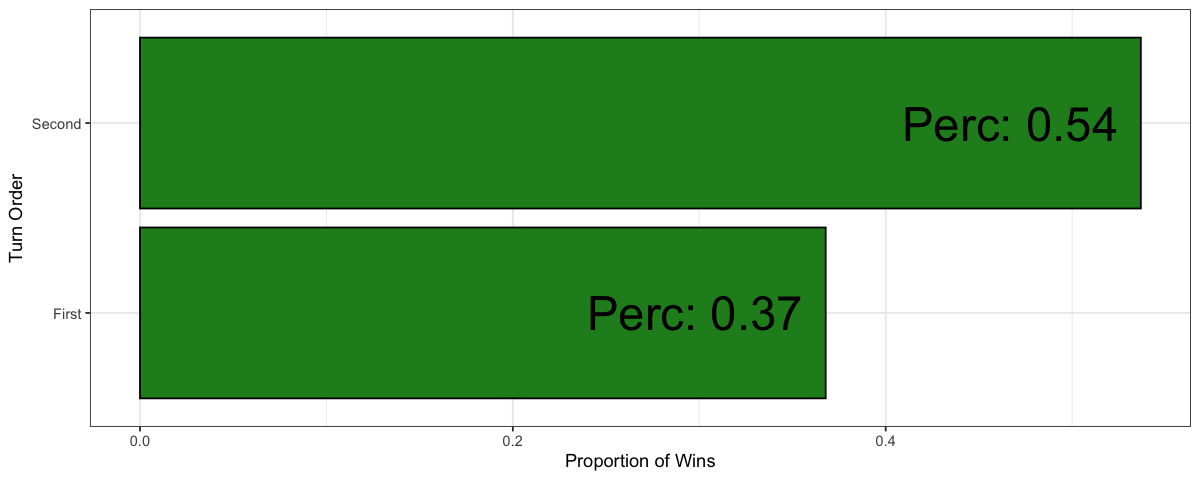

In [2]:
options(repr.plot.width = 10, repr.plot.height = 4)

win_by_order <- tcg |>
    group_by(Order) |>
    summarise(
        Win_Percentage = mean(Result == "Win"),
        Games = n(),
        Wins = sum(Result == "Win")
    )

ggplot(win_by_order) +
    aes(x = factor(Order), y = Win_Percentage) +
    geom_col(colour = 1, fill = "forestgreen") +
    labs(
        fill = NULL,
        x = "Turn Order",
        y = "Proportion of Wins"
    ) +
    geom_text(
        aes(label = str_c("Perc: ", round(Win_Percentage, 2))),
        nudge_y = -0.07, size = 10
    ) +
    coord_flip() 


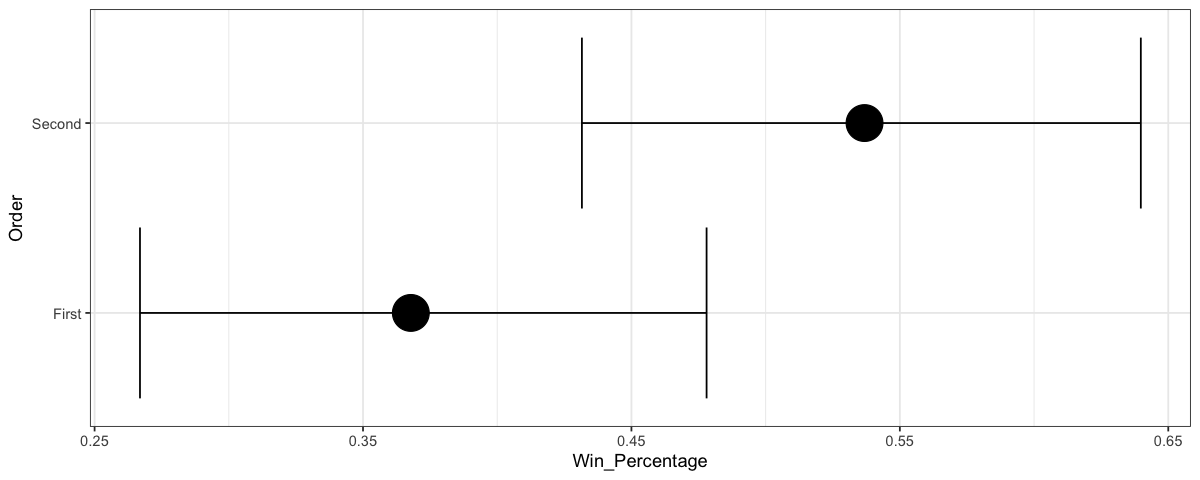

In [3]:
lo <- function(x, n) as.numeric(binom.test(x = x, n = n)$conf.int)[1]
hi <- function(x, n) as.numeric(binom.test(x = x, n = n)$conf.int)[2]

win_by_order |>
    rowwise() |>
    mutate(
        lo = lo(Wins, Games),
        hi = hi(Wins, Games)
    ) |>
    ggplot() +
    aes(x = Order, y = Win_Percentage, ymin = lo, ymax = hi) +
    geom_point(size = 10) +
    geom_errorbar() +
    coord_flip()


In [4]:
binom.test(x = win_by_order$Wins, n = win_by_order$Games, alternative = "less")



	Exact binomial test

data:  win_by_order$Wins
number of successes = 32, number of trials = 83, p-value = 0.02376
alternative hypothesis: true probability of success is less than 0.5
95 percent confidence interval:
 0.0000000 0.4814957
sample estimates:
probability of success 
             0.3855422 


**Conclusion**: This deck is statistically significantly more likely to lose when it goes first!

# Is the turn order truely random?

It has been claimed that the probability of heads increases if you're on a losing streak, as this encourages the player to keep playing. 

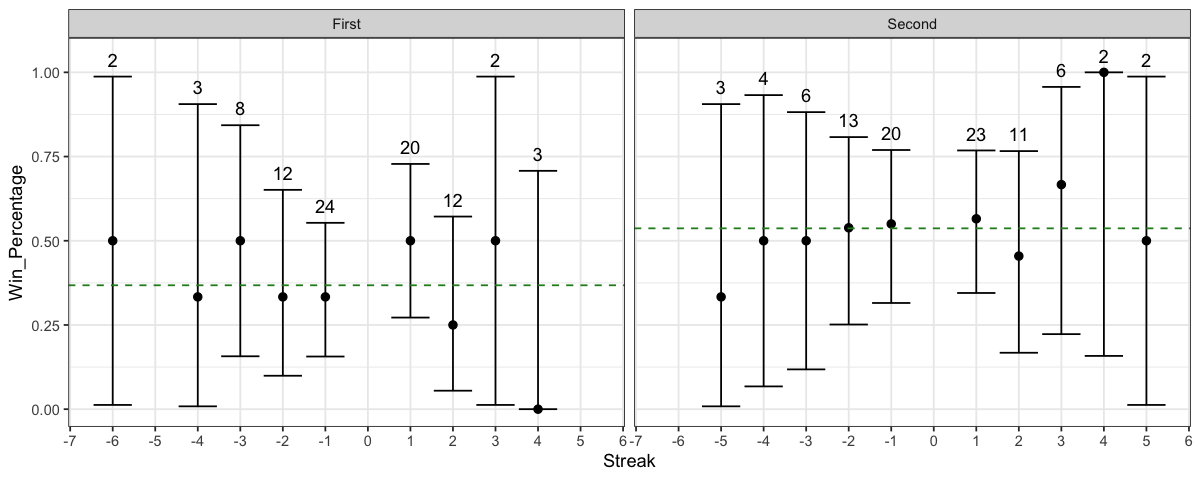

In [5]:
run_lengths <- rle(tcg$Result)[["lengths"]]
run_values <- rle(tcg$Result)[["values"]]

streak <- sapply(seq_along(run_lengths), function(x) {
    1:run_lengths[x] * ifelse(run_values[x] == "Win", 1, -1)
}) |> unlist()

tcg$Streak <- c(NA, streak[1:(length(streak) - 1)])
lo <- function(p, n) as.numeric(binom.test(x = round(p * n), n = n)$conf.int)[1]
hi <- function(p, n) as.numeric(binom.test(x = round(p * n), n = n)$conf.int)[2]

tcg |>
    group_by(Streak, Order) |>
    summarise(
        Win_Percentage = mean(Result == "Win"), Games =  n(),
        .groups = "drop"
    ) |>
    rowwise()|> 
    mutate(
        lo = lo(Win_Percentage, Games),
        hi = hi(Win_Percentage, Games)
    ) |>
    filter(Games > 1) |>
    ggplot() +
    aes(x = Streak, y = Win_Percentage) +
    geom_point(aes(colour = Streak > 0), na.rm = TRUE, colour = 1, size = 2) +
    geom_errorbar(aes(ymin = lo, ymax = hi), na.rm = TRUE) +
    geom_text(aes(y = hi, label = Games), na.rm = TRUE, nudge_y = 0.05) +
    theme(legend.position = "none") +
    scale_colour_manual(values = c("firebrick", "forestgreen")) +
    scale_x_continuous(breaks = -10:10, minor_breaks = NULL) +
    facet_wrap(~ Order) +
    geom_hline(
        aes(yintercept = Win_Percentage), data = win_by_order,
        colour = "forestgreen", linetype = "dashed"
    )


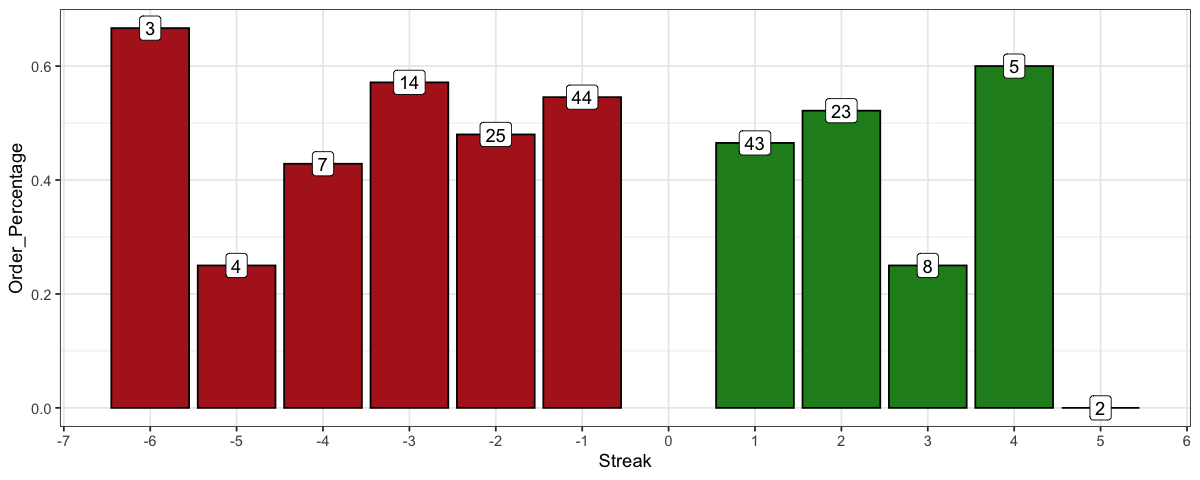

In [6]:

tcg |>
    group_by(Streak) |>
    summarise(
        Order_Percentage = mean(Order == "First"), Games =  n(),
        .groups = "drop"
    ) |>
    filter(Games > 1) |>
    ggplot() +
    aes(x = Streak, y = Order_Percentage) +
    geom_col(aes(fill = Streak > 0), na.rm = TRUE, colour = 1) +
    geom_label(aes(label = Games), na.rm = TRUE) +
    theme(legend.position = "none") +
    scale_fill_manual(values = c("firebrick", "forestgreen")) +
    scale_x_continuous(breaks = -10:10, minor_breaks = NULL)


**Claim**: If you're on a losing streak, the game tends to give you more heads when you flip coins.

The following test just checks if the sequence of coin flips that determines the order is completely random. It may not be specific enough to pick up on a subtle shift in coin probabilities after a specific losing streak.

In [7]:
tseries::runs.test(factor(tcg$Order))



	Runs Test

data:  factor(tcg$Order)
Standard Normal = -0.42066, p-value = 0.674
alternative hypothesis: two.sided


**Conclusion**: There does *not* seem to be a deviation from randomness in the heads and tails for choosing the order.

# An Exploration of Total Damage and Turns

Generally, getting more damage means you win. 

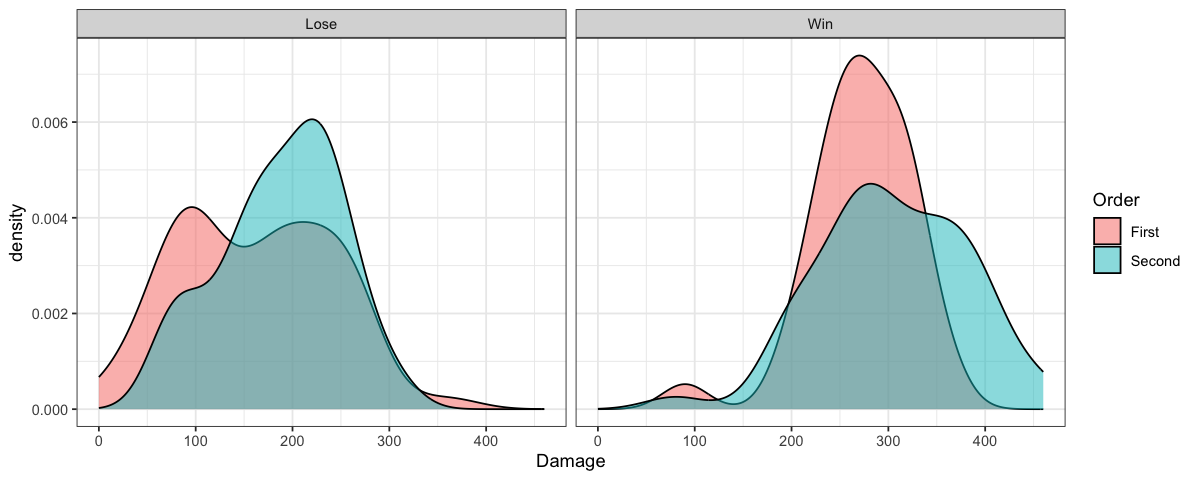

In [8]:
tcg |>
    ggplot() +
    aes(x = Damage, fill = Order) +
    geom_density(colour = 1, alpha = 0.5) +
    facet_wrap(~Result)


Win or lose, going second means dealing more damage!

In [9]:
tcg |>
    group_by(Order, Result) |>
    summarise(
        mean_damage = mean(Damage),
        max_damage = max(Damage),
        min_damage = min(Damage),
        .groups = "drop"
    ) |>
    pivot_longer(ends_with("damage"), names_to = "Stat", values_to = "value") |>
    pivot_wider(names_from = Order, values_from = value)
    

Result,Stat,First,Second
<chr>,<chr>,<dbl>,<dbl>
Lose,mean_damage,161.4545,188.1818
Lose,max_damage,360.0000,310.0000
Lose,min_damage,0.0000,70.0000
Win,mean_damage,271.5625,304.1176
Win,max_damage,360.0000,460.0000
Win,min_damage,90.0000,80.0000


In [10]:
lm_order <- lm(Damage ~ (Order + Turns) * Result, data = tcg)
summary(lm_order)



Call:
lm(formula = Damage ~ (Order + Turns) * Result, data = tcg)

Residuals:
     Min       1Q   Median       3Q      Max 
-175.211  -36.708   -0.145   40.644  134.774 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -57.1177    33.2872  -1.716 0.087939 .  
OrderSecond            40.2059    11.7186   3.431 0.000749 ***
Turns                  16.0286     2.3749   6.749 2.07e-10 ***
ResultWin              99.7021    47.4219   2.102 0.036937 *  
OrderSecond:ResultWin  14.7567    17.6928   0.834 0.405384    
Turns:ResultWin         0.8545     3.3598   0.254 0.799527    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 57.09 on 176 degrees of freedom
Multiple R-squared:  0.6313,	Adjusted R-squared:  0.6209 
F-statistic: 60.28 on 5 and 176 DF,  p-value: < 2.2e-16


The model above demonstrates that, among games that you win, going second means an increase of `40.2059 + 14.7567 = 54.9626` extra points, controlling for the number of turns. There is an approximate increase in damage of `40.2059` for games that you do not win.

(Obviously a causal model would fit better here, rather than an associational model that tells you a difference in points **given that** you know the result).

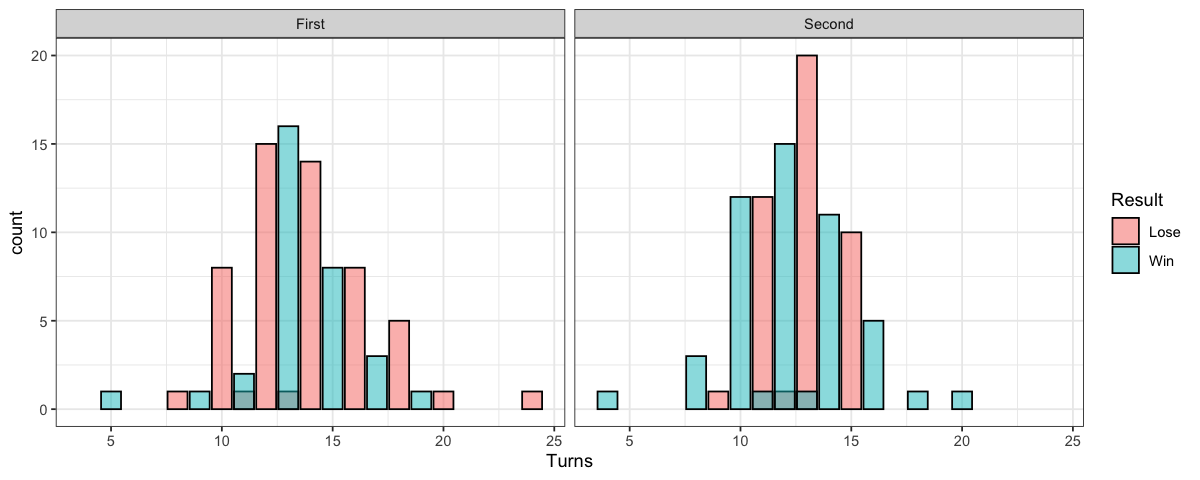

In [11]:
tcg |>
    ggplot() +
    aes(x = Turns, fill = Result) +
    geom_bar(position = "identity", alpha = 0.5, colour = 1) +
    facet_wrap(~ Order)


Because of how turns work, If you go first then you should either win on an odd turn or lose on an even turn. There are a few examples where this isn't the case, and I can't explain all of them. I did have a Grimer in the deck, and so poison damage potentially made the difference, but that's all I can say (no games were conceded). 